# Computing the Lagrangian Descriptors of Nonlinear Dynamical Systems

## Functions

__NOTE__: For testing, execute all the cells below before executing/modifying all the benchmark examples.

In [1]:
import numpy
import matplotlib.pyplot as plt

In [2]:
import scipy.integrate
integrator = scipy.integrate.solve_ivp # RK45 (default)

INPUT PARAMETERS

In [10]:
###################################
# Integration parameters
t0 = 0
tau = 12
dt = 0.1
###################################
# Lagrangian descriptor parameters
p_norm = 1/2
flag_m = True
###################################
# Mesh parameters
x_min,x_max = [-1.6, 1.6]
y_min,y_max = [-1, 1]
Nx, Ny = [300, 300]

GRID_PARAMETERS = [(x_min, x_max, Nx), (y_min, y_max, Ny)]

dim = 2
shape = (Nx*Ny, dim)
###################################
# Time Dependent Perurbation (for Hamilton Duffing)
flag_pert = 1;
perturbation_params = [0.15, 0.5]

In [11]:
def generate_points(GRID_PARAMETERS):
    x_min, x_max, Nx = GRID_PARAMETERS[0]
    y_min, y_max, Ny = GRID_PARAMETERS[1]
    mesh = numpy.zeros(shape) # Mesh to accumulate 
    points_x = numpy.linspace(x_min, x_max, Nx)
    points_y = numpy.linspace(y_min, y_max, Ny)    
    X, Y = numpy.meshgrid(points_x, points_y)  # Grid in pahse-space
    mesh[:,0] = X.T.reshape(-1)
    mesh[:,1] = Y.T.reshape(-1)
    return mesh

In [26]:
def flatten_array(points): return points.reshape(-1)
def recover_array(points_flat, shape=shape): return points_flat.reshape(shape)

Turn phase-space vector field to high-dimensional vector field

In [13]:
def vector_field_flat(t, points, vector_field):
    u = recover_array(points)
    v = vector_field(t, u)
    # Flatten output 
    v_flat = flatten_array(v)

    return v_flat

Extracts solution from solver

In [14]:
def extract_y_final(solution_object):
    y_final = solution_object.y.T[-1]
    return y_final

In [15]:
def accumulate_lagrangian_descriptor(LD, points_initial, points_now, p_norm = p_norm, flag_m = True):
    if flag_m: # p-norm LDs
        LD_accum = LD + ((abs(points_now[:,0] - points_initial[:,0]))**p_norm + (abs(points_now[:,1] - points_initial[:,1]))**p_norm) * dt ** (1 - p_norm);
    else:  # arclength LDs
        LD_accum = LD + sqrt((points_now[:,0] - points_now[:,0])**2 + (points_now[:,1] - points_initial[:,1])**2);
    return LD_accum

Removed `dt` and `p` from functions since these are global variables.

<span style='color:red'>What about flag_m?</span>

In [16]:
def compute_lagrangian_descriptor(points_initial, vector_field, time_interval, dt = dt, norm = False):
    f = vector_field_flat
    t_initial, t_final = time_interval
    if t_final < t_initial:
        dt = - dt
    else:
        dt = dt
    LD = numpy.zeros(Nx*Ny)  # Array to store forward LDs

    for t in numpy.arange(t_initial, t_final - dt, dt):
        ###################################
        # Inputs for integrator
        t_span = (t, t + dt)
        y0 = flatten_array(points_initial)
        ###################################
        # Outputs from integration
        solution_object = integrator(f, t_span, y0, args=(vector_field, ))
        points_final = extract_y_final(solution_object)
        points_final = recover_array(points_final)
        ###################################
        # Compute LD
        LD = accumulate_lagrangian_descriptor(LD, points_initial, points_final)
        ###################################
        # For next iteration
        points_initial = points_final
    return LD

Break down `lagrangian_descriptors` into separate code chunks

In [17]:
def draw_lagrangian_descriptor(LD, flag_m, flag_type):
    LD = LD.reshape(Nx, Ny).T # Reshape 1D array
#     LD = LD / LD.max()  # Scale LD output
    ###################################
    # Plot LDs
    fig,ax = plt.subplots(1,1,dpi=100)
    
    points_x = numpy.linspace(x_min, x_max, Nx)
    points_y = numpy.linspace(y_min, y_max, Ny)    
    X, Y = numpy.meshgrid(points_x, points_y)

    scatter = plt.scatter(X,Y,c=LD,cmap='bone')
    ###################################
    # Customise appearance
    if flag_m:
        str_meth = ' '.join(['p-norm (p=',str(p_norm),')--'])
    else:
        str_meth = 'arclength --'
    
    if flag_type == 1:
        string_title = ['Forward LDs ', str_meth, '(','$\\tau=$ ',str(tau),' , ','$t_0=$',str(t0),')']
    elif flag_type == 2:
        string_title = ['Backward LDs ', str_meth, '(','$\\tau=$ ',str(tau),' , ','$t_0=$',str(t0),')']
    else:
        string_title = ['LDs ', str_meth, '(','$\\tau=$ ',str(tau),' , ','$t_0=$',str(t0),')']
    
    string_title = ' '.join(string_title)
    
    ax.set_title(string_title, fontsize=12)
    ax.set_xlabel('x', fontsize=18)
    ax.set_ylabel('y', fontsize=18)
    ax.set_aspect('auto')

    fig.colorbar(scatter) # Add color bar

    plt.show()

# Benchmark examples

## Vector fields

Define vector field $f(x,y) = (f_1, f_2)$

For for the Initial Value problem 

\begin{align*}
    \dot{x} &= dx/dt = f_1(x,y)\\
    \dot{y} &= dy/dt = f_2(x,y)
\end{align*}

with initial condition $(x_0, y_0) \in \mathbb{R}^2$ at time $t_0 \geq 0$

In [18]:
def HamCenter1D(t, u):
    x, y = u.T
    # Hamiltonian Model Parameter
    omega = 1
    v = numpy.array([ omega * y, - omega * x]).T
    return v

In [19]:
def HamSaddle1D(t, u):
    x, y = u.T
    # Hamiltonian Model Parameter
    lamda = 1
    v = numpy.array([ lamda * y, lamda * x]).T
    return v

In [20]:
def forcing(t, u, flag_pert, perturbation_params):
    x, y = u.T
    pert = numpy.zeros((len(x),1))
    # Perturbation parameters
    A, freq = perturbation_params # Amplitude and Frequency
    if flag_pert == 1:
        perturbation = A * numpy.sin(freq*t)
    elif flag_pert == 2:
        perturbation = A * numpy.sech(t) * numpy.sin(freq*t)
    else:
        perturbation = perturbation
    
    return perturbation

In [21]:
def HamDuffing1D(t, u):
    x, y = u.T
    # Hamiltonian Model Parameter
    perturbation = forcing(t, u, flag_pert, perturbation_params)
    v = numpy.array([y, x - x**3 + perturbation]).T
    return v

## Input parameters

In [27]:
###################################
# Integration parameters
t0 = 0
tau = 12
dt = 0.1
###################################
# Lagrangian descriptor parameters
p_norm = 1/2
flag_m = True
###################################
# Mesh parameters
x_min,x_max = [-1.6, 1.6]
y_min,y_max = [-1, 1]
Nx, Ny = [300, 300]

GRID_PARAMETERS = [(x_min, x_max, Nx), (y_min, y_max, Ny)]

dim = 2
shape = (Nx*Ny, dim)
###################################
# Time Dependent Perurbation (for Hamilton Duffing)
flag_pert = 1;
perturbation_params = [0.15, 0.5]

## Compute and Visualise

### Hamilton Centre

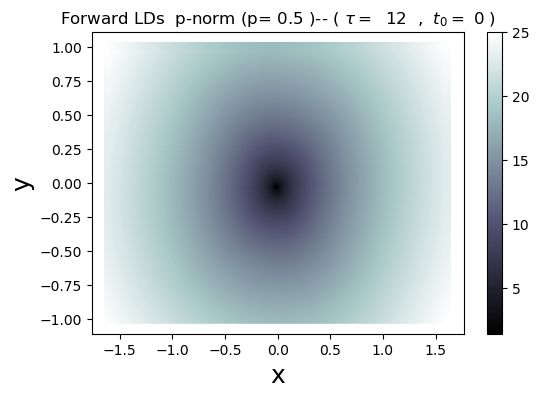

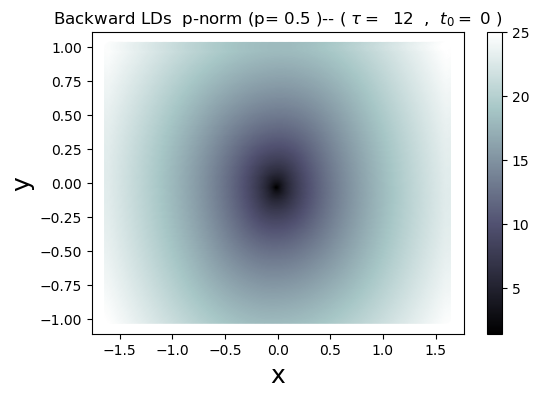

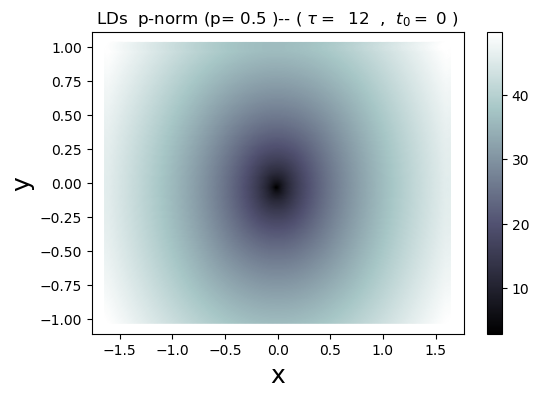

In [28]:
initial_conditions = generate_points(GRID_PARAMETERS)
vector_field = HamCenter1D

time_interval = (t0, t0 + tau)
LD_forward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval)
draw_lagrangian_descriptor(LD_forward, True, 1)

time_interval = (t0, t0 - tau)
LD_backward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval)
draw_lagrangian_descriptor(LD_backward, True, 2)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, True, 3)

### Hamilton Saddle

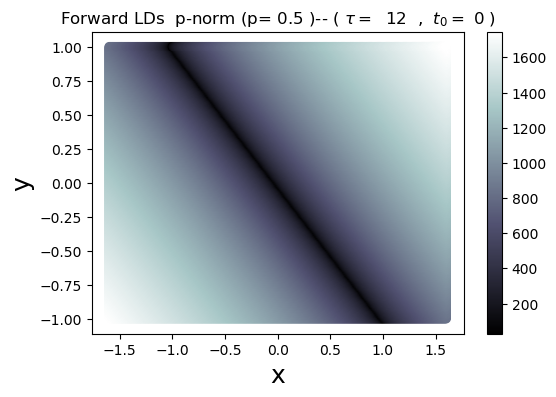

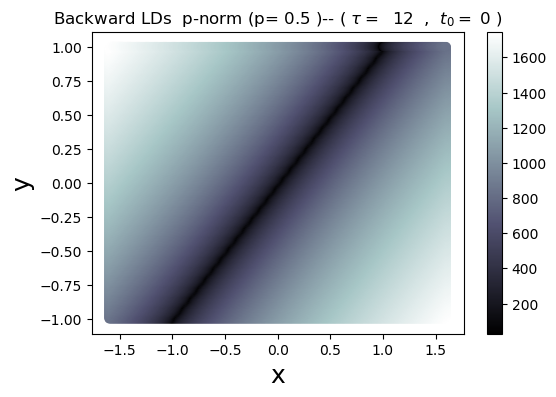

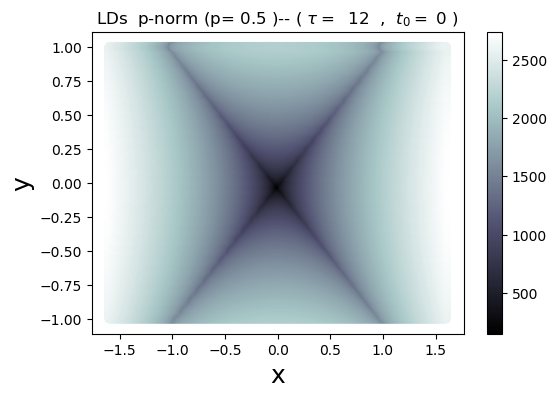

In [29]:
initial_conditions = generate_points(GRID_PARAMETERS)
vector_field = HamSaddle1D

time_interval = (t0, t0 + tau)
LD_forward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval)
draw_lagrangian_descriptor(LD_forward, True, 1)

time_interval = (t0, t0 - tau)
LD_backward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval)
draw_lagrangian_descriptor(LD_backward, True, 2)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, True, 3)

### Hamilton Duffing

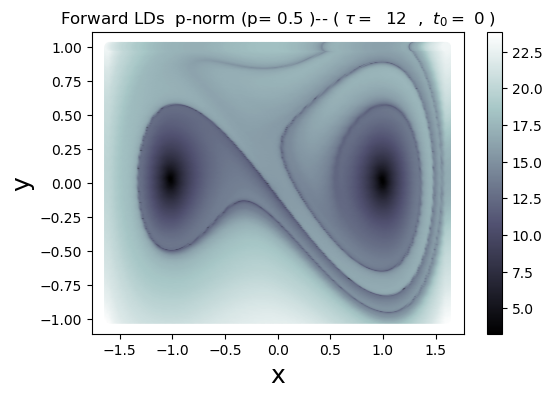

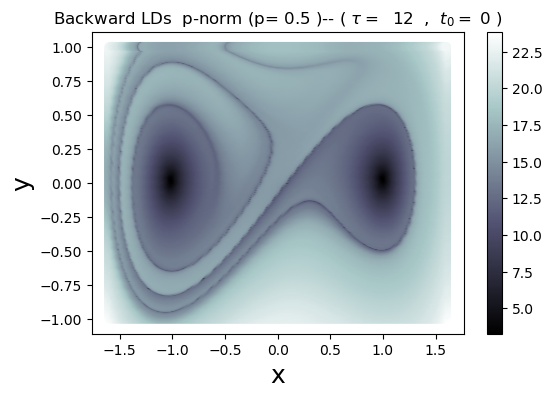

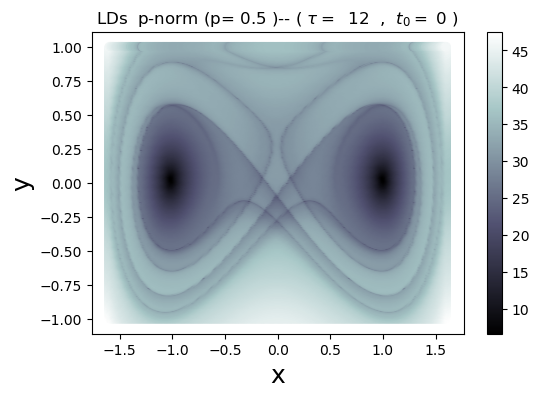

In [30]:
initial_conditions = generate_points(GRID_PARAMETERS)
vector_field = HamDuffing1D

time_interval = (t0, t0 + tau)
LD_forward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval)
draw_lagrangian_descriptor(LD_forward, True, 1)

time_interval = (t0, t0 - tau)
LD_backward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval)
draw_lagrangian_descriptor(LD_backward, True, 2)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, True, 3)

### Hamilton Saddle-Node (IN PROGRESS)

<span style='color:red'><b>TO-DO</b></span> Implement _Variable Time Integration_ for systems like the HSN

In [83]:
def HamSN1D(t, u):
    x, y = u.T
    # Hamiltonian Model Parameter
    v = numpy.array([ y, -x -x**2]).T
    return v

In [84]:
###################################
# Integration parameters
t0 = 0 # Initial time
tau = 1.5 # Time-interval length
dt = 0.1 # Timestep
###################################
# Lagrangian descriptor parameters
p_norm = 1/2 # p-value of Lp norm
flag_m = True
###################################
# Grid parameters
x_min,x_max = [-1.5, 1] # Grid limits X-axis
y_min,y_max = [-1, 1] # Grid limits Y-axis
Nx, Ny = [300, 300] # Number of points per axis

GRID_PARAMETERS = [(x_min, x_max, Nx), (y_min, y_max, Ny)]

dim = 2 # Phase-space Dimension
shape = (Nx*Ny, dim) # Shape of array of grid-points
###################################
# Time Dependent Perurbation (for Hamilton Duffing)
flag_pert = 1 
perturbation_params = [0.15, 0.5] # Amplitude & Frequency, periodic pertubation

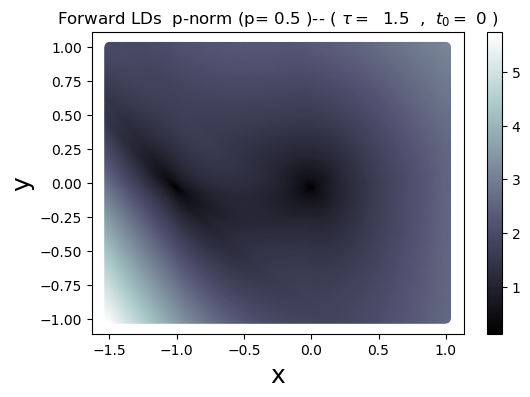

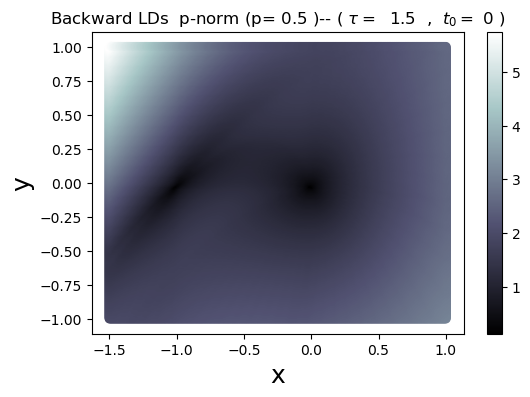

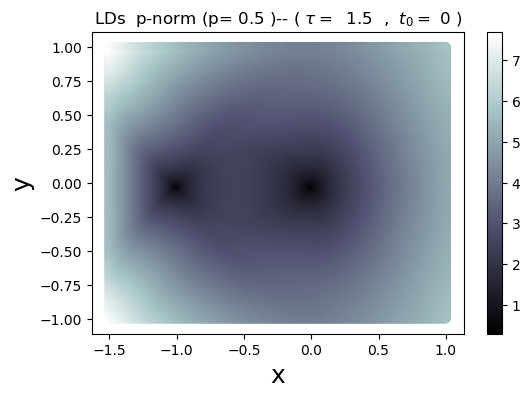

In [85]:
initial_conditions = generate_points(GRID_PARAMETERS)
vector_field = HamSN1D

# Compute and draw forward LD
time_interval = (t0, t0 + tau)
LD_forward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval)
draw_lagrangian_descriptor(LD_forward, True, 1)

# Compute and draw backward LD
time_interval = (t0, t0 - tau)
LD_backward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval)
draw_lagrangian_descriptor(LD_backward, True, 2)

# Compute and draw total LD
LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, True, 3)